In [3]:
from download_day import download_day
from load_saved_fd4 import load_saved_fd4
from scrape_aircraft_list import scrape_aircraft_list
from get_perf_model_typecodes import get_perf_model_typecodes 
from match_icao_model import match_icao_model
from process_airport_list import process_airport_list
from generate_flightpath import generate_flightpath
from plot_flightpaths import plot_flightpaths
from get_engine_data import get_engine_data
from perf_model_powerplant_parser import perf_model_powerplant_parser
from match_engine_to_emissions_db import match_engine_to_emissions_db
from process_month_emissions import process_month_emissions
from get_era5_wind import get_era5_wind
from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import tqdm
from time import sleep
from geopy import distance
import requests
from icet import icet
from bffm2 import bffm2
import multiprocessing
from functools import partial
import zipfile
import shutil


%matplotlib inline

# User Inputs:
start_time_str       = '2023-01-01T00:00:00Z'
stop_time_str        = '2023-12-31T23:59:59Z'
query_limit          = 15e4
send_notification    = True
make_plot            = True
output_dir           = "/scratch/omg28/Data/"

# Convert start and stop times to datetime objects
start_time_simple = pd.to_datetime(start_time_str).strftime("%Y-%m-%d")
stop_time_simple = pd.to_datetime(stop_time_str).strftime("%Y-%m-%d")
analysis_year = pd.to_datetime(start_time_str).year

# Define grid
lat_bins = np.arange(-90, 90.1, 0.5)
lon_bins = np.arange(-180, 180.1, 0.5)
alt_bins_ft = np.arange(0, 55001, 1000)
alt_bins_m = alt_bins_ft * 0.3048
nlat, nlon, nalt = len(lat_bins)-1, len(lon_bins)-1, len(alt_bins_m)-1

# Define countries whose airspace we want to exclude
conflict_countries = ['Russia', 'Ukraine', 'Libya', 'Syria', 'Sudan', 'Yemen']


In [ ]:
import glob

# Generate the file pattern for all daily flight data files in 2023
file_pattern = f"{output_dir}no_track2023/result_df_2023-*.pkl"
flight_files = glob.glob(file_pattern)

total_flights = 0
for file in flight_files:
    try:
        df = pd.read_pickle(file)
        total_flights += len(df)
    except Exception as e:
        print(f"Could not read {file}: {e}")

print(f"Total number of flights tracked in 2023: {total_flights:,}")

############### Count flights missing departure or arrival airport information##########
missing_airport_flights = 0
for file in flight_files:
    try:
        df = pd.read_pickle(file)
        # Count rows where either estdepartureairport or estarrivalairport is missing/null/empty
        missing = df['estdepartureairport'].isnull() | df['estarrivalairport'].isnull() | \
                  (df['estdepartureairport'] == '') | (df['estarrivalairport'] == '')
        missing_airport_flights += missing.sum()
    except Exception as e:
        print(f"Could not read {file}: {e}")

if total_flights > 0:
    proportion_missing = missing_airport_flights / total_flights
    print(f"Flights missing departure or arrival airport: {missing_airport_flights:,} ({proportion_missing:.2%})")
else:
    print("No flights found to analyze missing airport information.")
############ Counting flights in typecodes_added files for 2023 ############
# Count flights in typecodes_added files for 2023
# (glob and pandas are already imported above)

# Pattern for all monthly typecodes_added files for 2023
pattern = f"{output_dir}aircraftdb/2023-*_to_2023-*_150000_typecodes_added.pkl"
files = sorted(glob.glob(pattern))

total_typecodes_flights = 0
monthly_counts = {}

for file in files:
    df = pd.read_pickle(file)
    n = len(df)
    total_typecodes_flights += n
    # Extract month for reporting
    month = file.split('/')[-1].split('_')[0][5:7]
    monthly_counts[month] = n

print(f"Total number of flights in all typecodes_added files: {total_typecodes_flights:,}")

# Calculate and report the percentage of flights NOT in typecodes_added files
if total_flights > 0:
    missing_typecode_flights = total_flights - total_typecodes_flights
    percent_missing = (missing_typecode_flights / total_flights) * 100
    print(f"Flights missing typecode: {missing_typecode_flights:,} ({percent_missing:.2f}%)")
else:
    print("No flights found to analyze typecodes_added coverage.")


# Count the number and proportion of flights in 2023 done by helicopters
helicopter_flights = 0
for file in files:
    df = pd.read_pickle(file)
    # ICAO typecodes for helicopters typically start with 'H'
    helicopter_flights += df['typecode'].astype(str).str.startswith('H').sum()

print(f"Number of helicopter flights in 2023: {helicopter_flights:,}")

if total_flights > 0:
    helicopter_proportion = helicopter_flights / total_flights
    print(f"Proportion of total flights in 2023 done by helicopters: {helicopter_proportion:.2%}")
else:
    print("No flights found to analyze helicopter flights.")

eucontrol_typecodes = pd.read_csv("performance_models_typecodes.csv")['typecode'].unique()

eucontrol_flights = 0
for file in files:
    df = pd.read_pickle(file)
    eucontrol_flights += df['typecode'].isin(eucontrol_typecodes).sum()

print(f"Number of flights in 2023 with a typecode in the EUControl database: {eucontrol_flights:,}")

if total_flights > 0:
    eucontrol_proportion = eucontrol_flights / total_flights
    print(f"Proportion of total flights in 2023 with EUControl typecode: {eucontrol_proportion:.2%}")
else:
    print("No flights found to analyze EUControl typecode coverage.")
    
# count the total number or flights in 2023 with a 

Total number of flights tracked in 2023: 39,598,095
Flights missing departure or arrival airport: 13,267,658 (33.51%)
Total number of flights in all typecodes_added files: 23,748,899
Flights missing typecode: 15,849,196 (40.03%)
Number of helicopter flights in 2023: 206,576
Proportion of total flights in 2023 done by helicopters: 0.52%
Number of flights in 2023 with a typecode in the EUControl database: 19,803,773
Proportion of total flights in 2023 with EUControl typecode: 50.01%


# Section 1. Download flight information from Opensky

In [ ]:

# Download data from OpenSky history database
# WARNING: This may take a long time to run and will use a lot of disk space. Recommend running this in a .py script to avoid recurring memory issues found in Jupyter notebooks.
# download_day(start_time_str, stop_time_str, query_limit, send_notification, make_plot, output_dir)


# Section 2. Scrape the EUCONTROL database for aircraft flight performance information

In [ ]:
"""
# scrape the list of aircraft with performance models from the EUCONTROL website
perf_model_typecodes = get_perf_model_typecodes()
## WARNING: THIS CAN GET YOUR IP ADDRESS BLOCKED IF YOU RUN IT REPEATEDLY. IT IS A WEB SCRAPER.
aircraft_list = scrape_aircraft_list(perf_model_typecodes)

"""

In [ ]:
'''
# get the aircraft metadata database from the OpenSky network
os.system(f'wget -P {output_dir}aircraftdb https://s3.opensky-network.org/data-samples/metadata/aircraft-database-complete-2025-02.csv')

# get airport list from the ourairports database
os.system(f'wget -P {output_dir}airportdb https://davidmegginson.github.io/ourairports-data/airports.csv')

# Download the ICAO engine database from easa database and save it as a CSV file
xlsx_url = "https://www.easa.europa.eu/en/downloads/131424/en"
xlsx_path = "/scratch/omg28/Data/engine_data/engine_data_icao.xlsx"
csv_path = "/scratch/omg28/Data/engine_data/engine_data_icao.csv"

# Download the file if it doesn't exist
if not os.path.exists(xlsx_path):
    os.makedirs(os.path.dirname(xlsx_path), exist_ok=True)
    r = requests.get(xlsx_url)
    with open(xlsx_path, 'wb') as f:
        f.write(r.content)

# Read the specified sheet and save as CSV
df = pd.read_excel(xlsx_path, sheet_name='Gaseous Emissions and Smoke')
df.to_csv(csv_path, index=False)

# Get ERA5 wind reanalysis data for the specified time period
netcdf_path = get_era5_wind(analysis_year, output_dir)

# Download the country shapefiles
os.system(f'wget https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip')
'''


In [2]:
# remove the helicopters from the aircraft performance database list
perf_models = pd.read_csv("aircraft_performance_table.csv")
perf_models = perf_models[~perf_models['type'].str.contains('H')]
perf_models.to_csv("aircraft_performance_table_filtered.csv", index=False)
pd.to_pickle(perf_models, "aircraft_performance_table_filtered.pkl")
num_helicopters = pd.read_csv("aircraft_performance_table.csv")['type'].str.contains('H').sum()
print(f"Number of helicopters in the original database: {num_helicopters}")


Number of helicopters in the original database: 21


# Section 3. Process the aircraft performance and flight data, retaining only flights we have takeoff, landing, plane type, and aircraft performance model information about. Further, drop all flights with aircraft codes that do not correspond to a code in the ourairports registry.

In [7]:
# process the loaded time period of data. - 12s
# - matches 24 bit transponder codes from Feb 2025 aircraft metadata database with the ICAO typecode
# - removes all flights for which the transponder code does not have a corresponding ICAO typecode
# - removes all flights for which the takeoff OR landing airport is unknown
def process_month(start_time_str_loop):
    # Set end date to last day of month at 23:59:59 UTC
    stop_time_str_loop = (start_time_str_loop + pd.offsets.MonthEnd(1)).replace(hour=23, minute=59, second=59)
    start_time_simple_loop = pd.to_datetime(start_time_str_loop).strftime("%Y-%m-%d")
    stop_time_simple_loop = pd.to_datetime(stop_time_str_loop).strftime("%Y-%m-%d")
    print(f"Processing data from {start_time_str_loop} to {stop_time_str_loop}")

    flights_with_typecode = match_icao_model(str(start_time_str_loop), str(stop_time_str_loop), query_limit, 
                                            aircraft_db_path = "/scratch/omg28/Data/aircraftdb/aircraft-database-complete-2025-02.csv",
                                            flight_db_path = "/scratch/omg28/Data/no_track2023/",
                                            output_dir = "/scratch/omg28/Data/aircraftdb/")
    
    # Load in the list of ICAO typecodes that have a performance model - 7.5s
    performance_model_typecodes = pd.read_pickle('/scratch/omg28/Data/aircraftdb/performance_models_typecodes.pkl')

    # load in the list of all flights with typecode and takeoff/landing airport - uncomment this line to load the data from a .pkl file
    # instead of running the match_icao_model function
    # flights_with_typecode = pd.read_pickle(f'/scratch/omg28/Data/aircraftdb/{start_time_simple_loop}_to_{stop_time_simple_loop}_{int(query_limit)}_typecodes_added.pkl')

    # get info before the merge
    print("Before merging:")
    print(flights_with_typecode.info())

    # inner join the loaded year of data with the scraped aircraft list
    # - this will remove all flights for which the ICAO typecode does not have a corresponding performance model
    flights_with_perf_typecode = pd.merge(flights_with_typecode, performance_model_typecodes, how='inner', on = 'typecode')

    print("After merging:")
    print(flights_with_perf_typecode.info())

    # print a list of typecodes in complete_flights_perf_model that do not have a performance model
    missing_perf_models = flights_with_typecode[~flights_with_typecode['typecode'].isin(performance_model_typecodes['typecode'])]
    print("Aircraft models with observed flights, but no performance model: " + str(len(missing_perf_models['typecode'].unique())))
    print("total flights in 2024 with TOLD and typecode, but no performance model: " + str(len(missing_perf_models)))

    # print a list of typecodes in performance_model_typecodes that do not correspond to a flight
    missing_flights = performance_model_typecodes[~performance_model_typecodes['typecode'].isin(flights_with_typecode['typecode'])]
    print("Number of performance models with no flights: " + str(len(missing_flights['typecode'].unique())))
    print("Number of flights with TOLD, typecode, and performance model: " + str(len(flights_with_perf_typecode)))

    # count all flights starting and ending at the same airport
    num_flights_no_dist = len(flights_with_perf_typecode[flights_with_perf_typecode['estdepartureairport'] == flights_with_perf_typecode['estarrivalairport']])
    print("Number of flights with no distance: " + str(num_flights_no_dist))

    # remove all flights starting or ending at the same airport
    flights_with_perf_typecode_dist = flights_with_perf_typecode[flights_with_perf_typecode['estdepartureairport'] != flights_with_perf_typecode['estarrivalairport']]
    print("Number of flights with TOLD, typecode, performance model, and nonzero distance: " + str(len(flights_with_perf_typecode_dist)))

    # load the takeoff and landing airport location information to the dataframe. 18s
    all_airports = process_airport_list()

    # add the estimated departure airport location information to the dataframe
    # - this will remove all flights for which the departure airport is unknown
    flights_with_perf_typecode_dist_dep = pd.merge(flights_with_perf_typecode_dist, all_airports, how='inner', left_on = 'estdepartureairport', right_on = 'ident')
    flights_with_perf_typecode_dist_dep.rename(columns = {'latitude_deg': 'estdeparturelat', 'longitude_deg': 'estdeparturelong', 'elevation_ft': 'estdeparturealt_ft'}, inplace=True)
    flights_with_perf_typecode_dist_dep.drop(columns = ['ident', 'gps_code'], inplace=True)

    # count the number of flights with no departure airport in the database
    print("Number of flights with no departure airport location info in database: " + str(len(flights_with_perf_typecode_dist) - len(flights_with_perf_typecode_dist_dep)))

    # add the estimated arrival airport location information to the dataframe
    all_flights_filtered = pd.merge(flights_with_perf_typecode_dist_dep, all_airports, how='inner', left_on = 'estarrivalairport', right_on = 'ident')
    all_flights_filtered.rename(columns = {'latitude_deg': 'estarrivallat', 'longitude_deg': 'estarrivallong', 'elevation_ft': 'estarrivalalt_ft'}, inplace=True)
    all_flights_filtered.drop(columns = ['ident', 'gps_code', 'id_x', 'id_y'], inplace=True)
    
    # save the result to a pickle file
    output_dir_expanded = os.path.expanduser(output_dir)
    os.makedirs(output_dir_expanded, exist_ok=True)
    filename = os.path.join(output_dir_expanded, f"aircraftdb/{start_time_simple_loop}_to_{stop_time_simple_loop}_{int(query_limit)}_typecodes_airports_added.pkl")
    all_flights_filtered.to_pickle(filename)

    # count the number of flights with no arrival airport in the database
    print("Number of flights with no arrival airport location info in database: " + str(len(flights_with_perf_typecode_dist_dep) - len(all_flights_filtered)))
    print("Number of flights with TOLD, typecode, performance model, distance, and departure/arrival airport info: " + str(len(all_flights_filtered)))
    return filename

month_starts = pd.date_range(start=pd.to_datetime(start_time_str), end=pd.to_datetime(stop_time_str), freq='MS', tz='UTC')
with Pool(cpu_count() // 2) as pool:
    results = pool.map(process_month, month_starts)

Processing data from 2023-01-01 00:00:00+00:00 to 2023-01-31 23:59:59+00:00Processing data from 2023-03-01 00:00:00+00:00 to 2023-03-31 23:59:59+00:00Processing data from 2023-02-01 00:00:00+00:00 to 2023-02-28 23:59:59+00:00Processing data from 2023-04-01 00:00:00+00:00 to 2023-04-30 23:59:59+00:00Processing data from 2023-05-01 00:00:00+00:00 to 2023-05-31 23:59:59+00:00Processing data from 2023-06-01 00:00:00+00:00 to 2023-06-30 23:59:59+00:00Processing data from 2023-08-01 00:00:00+00:00 to 2023-08-31 23:59:59+00:00Processing data from 2023-07-01 00:00:00+00:00 to 2023-07-31 23:59:59+00:00Processing data from 2023-09-01 00:00:00+00:00 to 2023-09-30 23:59:59+00:00Processing data from 2023-10-01 00:00:00+00:00 to 2023-10-31 23:59:59+00:00
Processing data from 2023-11-01 00:00:00+00:00 to 2023-11-30 23:59:59+00:00Processing data from 2023-12-01 00:00:00+00:00 to 2023-12-31 23:59:59+00:00










There are 3183 unique typecodes in the aircraft database.
There are 3183 unique typecode

/home/omg28/ConflictTrails/match_icao_model.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  flight_df = pd.concat([flight_df, load_saved_fd4(current_day, flight_db_path, query_limit)], axis=0, ignore_index=True)
/home/omg28/ConflictTrails/match_icao_model.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  flight_df = pd.concat([flight_df, load_saved_fd4(current_day, flight_db_path, query_limit)], axis=0, ignore_index=True)
/home/omg28/ConflictTrails/match_icao_model.py:49: FutureWarning: 

Saved result_df to /scratch/omg28/Data/aircraftdb/2023-01-01_to_2023-01-31_150000_typecodes_added.pkl
Before merging:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1578257 entries, 0 to 1578256
Data columns (total 5 columns):
 #   Column               Non-Null Count    Dtype          
---  ------               --------------    -----          
 0   icao24               1578257 non-null  object         
 1   estdepartureairport  1578257 non-null  string[pyarrow]
 2   estarrivalairport    1578257 non-null  string[pyarrow]
 3   day                  1578257 non-null  int64[pyarrow] 
 4   typecode             1578114 non-null  object         
dtypes: int64[pyarrow](1), object(2), string[pyarrow](2)
memory usage: 60.6+ MB
None
Saved result_df to /scratch/omg28/Data/aircraftdb/2023-05-01_to_2023-05-31_150000_typecodes_added.pkl
Before merging:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2186984 entries, 0 to 2186983
Data columns (total 5 columns):
 #   Column               Dtype    

Total number of flights in all typecodes_added files: 23,748,899


# Section 4. Using the great circle distance, calculate the distance between the airport takeoff and landing.

In [ ]:
# calculate the great circle distance between the departure and arrival airports - 40s

# Ensure max_distances_all is defined before the loop
max_distances_all = pd.DataFrame(columns=['typecode', 'max_distance_km'])

def process_month_distance(args):
    start_time_str_loop, stop_time_str_loop, query_limit, output_dir = args
    start_time_simple_loop = pd.to_datetime(start_time_str_loop).strftime("%Y-%m-%d")
    stop_time_simple_loop = pd.to_datetime(stop_time_str_loop).strftime("%Y-%m-%d")
    all_flights_filtered = pd.read_pickle(f'/scratch/omg28/Data/aircraftdb/{start_time_simple_loop}_to_{stop_time_simple_loop}_{int(query_limit)}_typecodes_airports_added.pkl')
    all_flights_filtered['gc_km'] = all_flights_filtered.apply(
        lambda x: distance.great_circle((x['estdeparturelat'], x['estdeparturelong']), (x['estarrivallat'], x['estarrivallong'])).km, axis=1)
    all_flights_filtered['gc_FEAT_km'] = all_flights_filtered.apply(lambda x: 1.0387 * x['gc_km'] + 40.5, axis=1)
    pd.to_pickle(all_flights_filtered, f'{output_dir}/{start_time_simple_loop}_to_{stop_time_simple_loop}_filtered.pkl')
    all_flights_filtered = all_flights_filtered[all_flights_filtered['gc_FEAT_km'] > 200]
    print("Number of flights with TOLD, typecode, performance model, distance, and departure/arrival airport info over 200 km: " + str(len(all_flights_filtered)))
    max_distances_month = all_flights_filtered.groupby('typecode')['gc_FEAT_km'].max().reset_index()
    max_distances_month.columns = ['typecode', 'max_distance_km']
    
    
    max_distances_month.to_csv(f'{output_dir}/aircraftdb/{start_time_simple_loop}_to_{stop_time_simple_loop}_typecode_max_distances.csv', index=False)
    return max_distances_month

# Prepare arguments for each month
month_args = []
for start_time_str_loop in pd.date_range(start=pd.to_datetime(start_time_str), end=pd.to_datetime(stop_time_str), freq='MS', tz='UTC'):
    stop_time_str_loop = (start_time_str_loop + pd.offsets.MonthEnd(1)).replace(hour=23, minute=59, second=59)
    month_args.append((start_time_str_loop, stop_time_str_loop, query_limit, output_dir))

with Pool(cpu_count() // 2) as pool:
    max_distances_list = pool.map(process_month_distance, month_args)

# Merge all max_distances_month DataFrames and keep the maximum for each typecode
if max_distances_list:
    max_distances_all = pd.concat(max_distances_list).groupby('typecode', as_index=False)['max_distance_km'].max()
    # Save the merged max distances dataframe to a .csv file (for the whole period)
    max_distances_all.to_csv(f'{output_dir}/aircraftdb/{start_time_simple}_to_{stop_time_simple}_typecode_max_distances.csv', index=False)


# Section 4.5: Process all flights to determine if their GC route is affected by conflict or not.

In [ ]:

# CODE WILL EXECUTE UPON IMPORTING THIS MODULE. CONSIDER CHANGING IN LATER VERSIONS.
# FIXME: Decide whether to run this as a .py or in the ipynb notebook.

# from label_conflict import label_conflict


In [ ]:
# plotting testcode
''''''
# plotting the flight paths with conflict zones
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point
import numpy as np
from matplotlib.lines import Line2D
from geopy import distance
from geographiclib.geodesic import Geodesic

testerrrrr = pd.read_pickle('/scratch/omg28/Data/2023-01-01_to_2023-01-31_labeled.pkl')[0:10000]

def create_geodesic_line(lon1, lat1, lon2, lat2, num_points=100):
    """Create a geodesic line between two points using WGS84 ellipsoid"""
    geod = Geodesic.WGS84
    line = geod.InverseLine(lat1, lon1, lat2, lon2)
    
    # Generate points along the geodesic
    points = []
    for i in range(num_points):
        s = (i / (num_points - 1)) * line.s13
        g = line.Position(s)
        points.append((g['lon2'], g['lat2']))
    
    return points

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Load world boundaries
try:
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
except (AttributeError, KeyError):
    world = gpd.read_file('ne_110m_admin_0_countries.zip')

# Plot world map as background
world.plot(ax=ax, color='lightgray', edgecolor='white', alpha=0.7)

# Create conflict zone masks
name_col = 'NAME' if 'NAME' in world.columns else 'name'
conflict_zones = world[world[name_col].isin(conflict_countries)]

# Create 1 degree buffers for conflict countries
conflict_buffered = conflict_zones.geometry.buffer(1.0)

# Plot conflict zones with transparency
conflict_buffered.plot(ax=ax, color='red', alpha=0.3, label='Conflict Zones (1° Buffer)')

# Plot flight paths with geodesic routes
for idx, flight in testerrrrr.iterrows():
    geodesic_points = create_geodesic_line(
        flight['estdeparturelong'], flight['estdeparturelat'],
        flight['estarrivallong'], flight['estarrivallat']
    )
    points = np.array(geodesic_points)
    lons = points[:, 0]
    lats = points[:, 1]

    # Find where the longitude jumps more than 180 degrees (dateline crossing)
    lon_diff = np.abs(np.diff(lons))
    split_indices = np.where(lon_diff > 180)[0] + 1

    # Split the points at the dateline
    segments = np.split(points, split_indices)

    color = 'orange' if flight['crosses_conflict'] else 'blue'
    alpha = 0.8 if flight['crosses_conflict'] else 0.3

    for seg in segments:
        # Only plot if segment has more than 1 point
        if len(seg) < 2:
            continue
        # Do not shift longitudes; just plot as-is to avoid horizontal lines
        line = LineString(seg)
        gdf_line = gpd.GeoDataFrame([1], geometry=[line])
        gdf_line.plot(ax=ax, color=color, alpha=alpha, linewidth=0.5)

# Add labels and formatting
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Geodesic Flight Paths with Conflict Zone Analysis')

# Create custom legend
legend_elements = [
    Line2D([0], [0], color='blue', alpha=0.3, label='Normal Flights'),
    Line2D([0], [0], color='orange', alpha=0.8, label='Conflict-Affected Flights'),
    plt.Rectangle((0, 0), 1, 1, facecolor='red', alpha=0.3, label='Conflict Zones (1° Buffer)')
]
ax.legend(handles=legend_elements, loc='lower left', fontsize='small')

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
conflict_flights = testerrrrr['crosses_conflict'].sum()
total_flights = len(testerrrrr)
print(f"Total flights: {total_flights}")
print(f"Conflict-affected flights: {conflict_flights}")
print(f"Percentage affected: {conflict_flights/total_flights*100:.1f}%")



/tmp/ipykernel_168378/67941860.py:46: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  conflict_buffered = conflict_zones.geometry.buffer(1.0)


/tmp/ipykernel_168378/3010224953.py:45: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  conflict_buffered_east = conflict_zones_east.geometry.buffer(1.0)


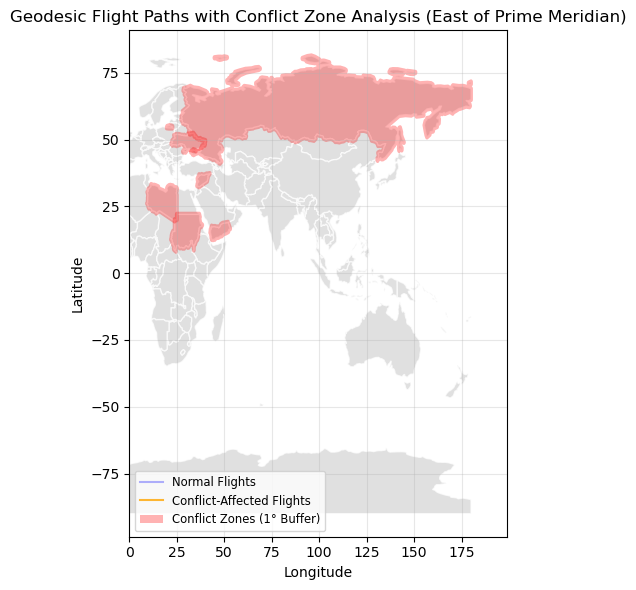

In [7]:
# plotting testcode
''''''
# plotting the flight paths with conflict zones
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point
import numpy as np
from matplotlib.lines import Line2D
from geopy import distance
from geographiclib.geodesic import Geodesic

testerrrrr = pd.read_pickle('/scratch/omg28/Data/2023-01-01_to_2023-01-31_labeled.pkl')[0:10]

def create_geodesic_line(lon1, lat1, lon2, lat2, num_points=100):
    """Create a geodesic line between two points using WGS84 ellipsoid"""
    geod = Geodesic.WGS84
    line = geod.InverseLine(lat1, lon1, lat2, lon2)
    
    # Generate points along the geodesic
    points = []
    for i in range(num_points):
        s = (i / (num_points - 1)) * line.s13
        g = line.Position(s)
        points.append((g['lon2'], g['lat2']))
    
    return points

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Load world boundaries
try:
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
except (AttributeError, KeyError):
    world = gpd.read_file('ne_110m_admin_0_countries.zip')

# Plot world map as background (only east of prime meridian)
world_east = world[world.geometry.bounds.maxx > 0]
world_east.plot(ax=ax, color='lightgray', edgecolor='white', alpha=0.7)

# Create conflict zone masks (only east of prime meridian)
name_col = 'NAME' if 'NAME' in world.columns else 'name'
conflict_zones_east = conflict_zones[conflict_zones.geometry.bounds.maxx > 0]
conflict_buffered_east = conflict_zones_east.geometry.buffer(1.0)
conflict_buffered_east.plot(ax=ax, color='red', alpha=0.3, label='Conflict Zones (1° Buffer)')

# Plot flight paths with geodesic routes (only if both endpoints east of prime meridian)
for idx, flight in testerrrrr.iterrows():
    if flight['estdeparturelong'] > 0 and flight['estarrivallong'] > 0:
        geodesic_points = create_geodesic_line(
            flight['estdeparturelong'], flight['estdeparturelat'],
            flight['estarrivallong'], flight['estarrivallat']
        )
        points = np.array(geodesic_points)
        lons = points[:, 0]
        lats = points[:, 1]

        # Find where the longitude jumps more than 180 degrees (dateline crossing)
        lon_diff = np.abs(np.diff(lons))
        split_indices = np.where(lon_diff > 180)[0] + 1

        # Split the points at the dateline
        segments = np.split(points, split_indices)

        color = 'orange' if flight['crosses_conflict'] else 'blue'
        alpha = 0.8 if flight['crosses_conflict'] else 0.3

        for seg in segments:
            if len(seg) < 2:
                continue
            line = LineString(seg)
            gdf_line = gpd.GeoDataFrame([1], geometry=[line])
            gdf_line.plot(ax=ax, color=color, alpha=alpha, linewidth=0.5)

# Add labels and formatting
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Geodesic Flight Paths with Conflict Zone Analysis (East of Prime Meridian)')
ax.set_xlim(left=0)  # Only show east of prime meridian

# Create custom legend
legend_elements = [
    Line2D([0], [0], color='blue', alpha=0.3, label='Normal Flights'),
    Line2D([0], [0], color='orange', alpha=0.8, label='Conflict-Affected Flights'),
    plt.Rectangle((0, 0), 1, 1, facecolor='red', alpha=0.3, label='Conflict Zones (1° Buffer)')
]
ax.legend(handles=legend_elements, loc='lower left', fontsize='small')

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [14]:
# Count the proportion of flights affected by conflict across all years
total_conflict_flights = 0
total_all_flights = 0

# Loop through all months in the analysis period
for start_time_str_loop in pd.date_range(start=pd.to_datetime(start_time_str), end=pd.to_datetime(stop_time_str), freq='MS', tz='UTC'):
    stop_time_str_loop = (start_time_str_loop + pd.offsets.MonthEnd(1)).replace(hour=23, minute=59, second=59)
    start_time_simple_loop = pd.to_datetime(start_time_str_loop).strftime("%Y-%m-%d")
    stop_time_simple_loop = pd.to_datetime(stop_time_str_loop).strftime("%Y-%m-%d")
    
    # Load the labeled flight data for this month
    try:
        month_flights = pd.read_pickle(f'/scratch/omg28/Data/{start_time_simple_loop}_to_{stop_time_simple_loop}_labeled.pkl')
        
        # Count flights for this month
        month_conflict_flights = month_flights['crosses_conflict'].sum()
        month_total_flights = len(month_flights)
        
        total_conflict_flights += month_conflict_flights
        total_all_flights += month_total_flights
        
        print(f"{start_time_str_loop.strftime('%B %Y')}: {month_conflict_flights:,} conflict-affected flights out of {month_total_flights:,} total flights ({month_conflict_flights/month_total_flights*100:.2f}%)")
        
    except FileNotFoundError:
        print(f"Warning: No labeled data found for {start_time_str_loop.strftime('%B %Y')}")
        continue

# Calculate overall statistics
if total_all_flights > 0:
    overall_percentage = total_conflict_flights / total_all_flights * 100
    print(f"\nOverall {analysis_year} Summary:")
    print(f"Total flights: {total_all_flights:,}")
    print(f"Conflict-affected flights: {total_conflict_flights:,}")
    print(f"Overall percentage affected: {overall_percentage:.2f}%")
else:
    print("No flight data found for the analysis period")

January 2023: 54,894 conflict-affected flights out of 1,132,523 total flights (4.85%)
February 2023: 50,737 conflict-affected flights out of 1,171,421 total flights (4.33%)
March 2023: 63,628 conflict-affected flights out of 1,391,306 total flights (4.57%)
April 2023: 61,464 conflict-affected flights out of 1,405,934 total flights (4.37%)
May 2023: 70,905 conflict-affected flights out of 1,525,551 total flights (4.65%)
June 2023: 72,797 conflict-affected flights out of 1,499,402 total flights (4.86%)
July 2023: 74,648 conflict-affected flights out of 1,537,268 total flights (4.86%)
August 2023: 79,864 conflict-affected flights out of 1,619,778 total flights (4.93%)
September 2023: 71,510 conflict-affected flights out of 1,545,430 total flights (4.63%)
October 2023: 47,953 conflict-affected flights out of 1,240,925 total flights (3.86%)
November 2023: 48,764 conflict-affected flights out of 1,361,334 total flights (3.58%)
December 2023: 47,092 conflict-affected flights out of 1,203,188 

# Section 5: parse the engine data and emissions data and add it to the aircraft performance model.

In [5]:
# Loads data from the saved engine data .csv files for analysis. Saves this dataframe to a .pkl file
# Setting "remove_superseded" to True will remove all engines that are superseded by an updated emissions model
engine_models = get_engine_data(update_superseded=False)
engine_models_removed = get_engine_data(update_superseded=True)
# calculate how many engines were removed
print("Number of engines that would be removed: " + str(len(engine_models['Engine Identification'].unique()) - len(engine_models_removed['Engine Identification'].unique())))
# print the list of the engine models that are in engine_models_kept but not in engine_models_removed
superseded_not_replaced = engine_models[~engine_models['Engine Identification'].isin(engine_models_removed['Engine Identification'])].get('Engine Identification').unique()
print("List of engines that were removed: " + str(superseded_not_replaced))
# POTENTIAL FIX: REMOVE ENGINES THAT HAVE BEEN SUPERSEDED BY AN UPDATED EMISSIONS MODE


Data loaded from /scratch/omg28/Data/engine_data/engine_data_icao.csv and saved to /scratch/omg28/Data/engine_data/engine_data_icao.pkl
Data loaded from /scratch/omg28/Data/engine_data/engine_data_icao.csv and saved to /scratch/omg28/Data/engine_data/engine_data_icao.pkl
Number of engines that would be removed: 21
List of engines that were removed: ['AE3007A1 series' 'LEAP-1B28' 'LEAP-1B28B2' 'LEAP-1B28/28B2/28B1/28B3'
 'CF34-10A16' 'CF34-3B' 'AS907-1-1A' 'HTF7250G (AS907-2-1G)'
 'HTF7350 (AS907-2-1A)' 'HTF7500E (AS907-3-1E-A1)'
 'HTF7500E (AS907-3-1E-A2)' 'HTF7500E (AS907-3-1E-A3)'
 'HTF7700L (AS907-2-1S)' 'PW308C' 'PW4x60' 'Trent 1000-A' 'Trent 1000-C'
 'Trent 1000-D' 'Trent 1000-E' 'Trent 1000-G' 'Trent 1000-H']


In [7]:
# loads the aircraft performance model data from the saved .csv file
performance_models = pd.read_csv("aircraft_performance_table_filtered.csv")

In [8]:
# extracts the powerplant data from the performance model dataframe and appends it to new columns in the performance model dataframe
allowed_manufacturers = engine_models['Manufacturer'].unique().tolist()
performance_models = perf_model_powerplant_parser(performance_models, coerce_manufacturer=True, allowed_manufacturers=allowed_manufacturers)


In [9]:
# 12s - attempts to match the powerplants extracted from the EUCONTROL aircraft performance model with an engine model in the engine emissions database
# reset the index of engine_models so that 'UID No' becomes a column rather than the index, otherwise the merge will not work
engine_models.reset_index(inplace=True)
# attempts to match the powerplants extracted from the EUCONTROL aircraft performance model with an engine model in the engine emissions database
performance_models_matched = match_engine_to_emissions_db(performance_models, engine_models)

In [10]:
# from all rows without a matched engine model
performance_models_matched = performance_models_matched.dropna(subset=['matched_engine_id'])

In [13]:
# print number of performance models whose engines match superseded engines
print("Number of performance models with engines that are superseded: " + str(len(performance_models_matched[performance_models_matched['matched_engine_id'].isin(superseded_not_replaced)])))
print("Number of performance models with engines that are NOT superseded: " + str(len(performance_models_matched[~performance_models_matched['matched_engine_id'].isin(superseded_not_replaced)])))
print("aircraft performance models with engines that are superseded: \n" + str(performance_models_matched[performance_models_matched['matched_engine_id'].isin(superseded_not_replaced)].get('typecode')))

Number of performance models with engines that are superseded: 10
Number of performance models with engines that are NOT superseded: 209
aircraft performance models with engines that are superseded: 
23     A388
61     B37M
62     B38M
63     B39M
64     B3XM
100    B788
101    B789
169    CL35
175    CRJ2
243    G280
Name: typecode, dtype: object


In [12]:
# Join the aircraft performance model data with the engine emissions database data
performance_and_emissions_model = pd.merge(performance_models_matched, engine_models, how='inner', left_on='matched_engine_uid_no', right_on='UID No')
pd.to_pickle(performance_and_emissions_model, "performance_and_emissions_model.pkl")

# Section 6: generate and visualize flightpath

In [ ]:
# performance_data=pd.read_pickle('aircraft_performance_data_table.pkl')
performance_and_emissions_model = pd.read_pickle('performance_and_emissions_model.pkl')
aircraft_typecode = 'A320'
flightpath = generate_flightpath(aircraft_typecode, 500, performance_and_emissions_model)

In [ ]:
import matplotlib.pyplot as plt
# Sum durations from the flightpath dictionary for each phase
climb_time = (flightpath['climb'].get('t_climb_0_5', 0) +
              flightpath['climb'].get('t_climb_5_10', 0) +
              flightpath['climb'].get('t_climb_10_15', 0) +
              flightpath['climb'].get('t_climb_15_24', 0) +
              flightpath['climb'].get('t_climb_ceil', 0))

descent_time = (flightpath['descent'].get('t_descent_5_0', 0) +
                flightpath['descent'].get('t_descent_10_5', 0) +
                flightpath['descent'].get('t_descent_15_10', 0) +
                flightpath['descent'].get('t_descent_24_15', 0) +
                flightpath['descent'].get('t_descent_ceil', 0))

cruise_time = flightpath['cruise'].get('t_cruise', 0)

# Prepare data for the barchart
phases = ['Climb', 'Cruise', 'Descent']
durations = [climb_time, cruise_time, descent_time]

# Optionally convert seconds to minutes (or leave in seconds)
# durations = [t / 60.0 for t in durations]

plt.figure()
bars = plt.bar(phases, durations, color=['skyblue', 'lightgreen', 'salmon'])
plt.xlabel('Flight Phases')
plt.ylabel('Duration (seconds)')
plt.title(f'Duration of Each Flight Leg ({aircraft_typecode})')

# Annotate bars with duration values
for bar, duration in zip(bars, durations):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height,
             f'{duration:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
# Break down the climb phases
climb_labels = ['Climb 0-5', 'Climb 5-10', 'Climb 10-15', 'Climb 15-24', 'Climb Ceil']
climb_times = [
    flightpath['climb'].get('t_climb_0_5', 0),
    flightpath['climb'].get('t_climb_5_10', 0),
    flightpath['climb'].get('t_climb_10_15', 0),
    flightpath['climb'].get('t_climb_15_24', 0),
    flightpath['climb'].get('t_climb_ceil', 0)
]

# Break down the descent phases
descent_labels = ['Descent 5-0', 'Descent 10-5', 'Descent 15-10', 'Descent 24-15', 'Descent Ceil']
descent_times = [
    flightpath['descent'].get('t_descent_5_0', 0),
    flightpath['descent'].get('t_descent_10_5', 0),
    flightpath['descent'].get('t_descent_15_10', 0),
    flightpath['descent'].get('t_descent_24_15', 0),
    flightpath['descent'].get('t_descent_ceil', 0)
]

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Climb segments chart
plt.subplot(1, 2, 1)
bars_climb = plt.bar(climb_labels, climb_times, color='skyblue')
plt.xlabel('Climb Segments')
plt.ylabel('Time (seconds)')
plt.title(f'Climb Phase Breakdown ({aircraft_typecode})')
for bar, t in zip(bars_climb, climb_times):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{t:.1f}', ha='center', va='bottom')

# Descent segments chart
plt.subplot(1, 2, 2)
bars_descent = plt.bar(descent_labels, descent_times, color='salmon')
plt.xlabel('Descent Segments')
plt.ylabel('Time (seconds)')
plt.title(f'Descent Phase Breakdown ({aircraft_typecode})')
for bar, t in zip(bars_descent, descent_times):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{t:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

import matplotlib.pyplot as plt

# Overall phase distances (in meters)
climb_distance = (np.atleast_1d(flightpath['climb'].get('s_climb_0_5', 0))[0] +
                  np.atleast_1d(flightpath['climb'].get('s_climb_5_10', 0))[0] +
                  np.atleast_1d(flightpath['climb'].get('s_climb_10_15', 0))[0] +
                  np.atleast_1d(flightpath['climb'].get('s_climb_15_24', 0))[0] +
                  np.atleast_1d(flightpath['climb'].get('s_climb_ceil', 0))[0])

cruise_distance = np.atleast_1d(flightpath['cruise'].get('s_cruise', 0))[0]

descent_distance = (np.atleast_1d(flightpath['descent'].get('s_descent_5_0', 0))[0] +
                    np.atleast_1d(flightpath['descent'].get('s_descent_10_5', 0))[0] +
                    np.atleast_1d(flightpath['descent'].get('s_descent_15_10', 0))[0] +
                    np.atleast_1d(flightpath['descent'].get('s_descent_24_15', 0))[0] +
                    np.atleast_1d(flightpath['descent'].get('s_descent_ceil', 0))[0])

phases = ['Climb', 'Cruise', 'Descent']
distances = [climb_distance, cruise_distance, descent_distance]

plt.figure(figsize=(8, 6))
overall_bars = plt.bar(phases, distances, color=['skyblue', 'lightgreen', 'salmon'])
plt.xlabel('Flight Phases')
plt.ylabel('Distance (meters)')
plt.title(f'Distance Covered in Each Flight Phase ({aircraft_typecode})')

# Annotate overall bars with distance values
for bar, dist in zip(overall_bars, distances):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{dist:,.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:


# Breakdown of distances for each segment

# For Climb Phase
climb_keys = ['s_climb_0_5', 's_climb_5_10', 's_climb_10_15', 's_climb_15_24', 's_climb_ceil']
climb_distances = []
for key in climb_keys:
    value = flightpath['climb'].get(key, np.array([0]))
    # value is expected to be a numpy array; extract its first element if so
    if isinstance(value, np.ndarray):
        climb_distances.append(value[0])
    else:
        climb_distances.append(value)

# For Descent Phase
descent_keys = ['s_descent_5_0', 's_descent_10_5', 's_descent_15_10', 's_descent_24_15', 's_descent_ceil']
descent_distances = []
for key in descent_keys:
    value = flightpath['descent'].get(key, np.array([0]))
    if isinstance(value, np.ndarray):
        descent_distances.append(value[0])
    else:
        descent_distances.append(value)

plt.figure(figsize=(14, 6))

# Climb segments chart
plt.subplot(1, 2, 1)
bars_climb = plt.bar(climb_labels, climb_distances, color='skyblue')
plt.xlabel('Climb Segments')
plt.ylabel('Distance (meters)')
plt.title(f'Climb Phase Distance Breakdown ({aircraft_typecode})')
for bar, d in zip(bars_climb, climb_distances):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{d:,.0f}', ha='center', va='bottom')

# Descent segments chart
plt.subplot(1, 2, 2)
bars_descent = plt.bar(descent_labels, descent_distances, color='salmon')
plt.xlabel('Descent Segments')
plt.ylabel('Distance (meters)')
plt.title(f'Descent Phase Distance Breakdown ({aircraft_typecode})')
for bar, d in zip(bars_descent, descent_distances):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{d:,.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
# Build cumulative distance and altitude lists.
# Starting at runway: (distance, altitude) = (0, 0)
distances_list = [0]
altitudes_list = [0]

# Climb phase:
# First climb segment (0-5):
cum_distance = distances_list[-1]
for key in flightpath:
    for key2 in flightpath[key]:
        if key2.startswith('s_'):
            cum_distance += flightpath[key][key2]
            distances_list.append(cum_distance)
            altitudes_list.append(flightpath[key][f'{key2.replace('s_', 'h_')}_end'])

# Plot the altitude profile vs. cumulative flight distance.
plt.figure(figsize=(10, 6))
plt.plot(distances_list, altitudes_list, marker='o', linestyle='-')
plt.xlabel('Cumulative Flight Distance (meters)')
plt.ylabel('Flight Altitude (meters)')
plt.title(f'Flight Altitude vs. Flight Distance ({aircraft_typecode})')
plt.grid(True)
plt.show()

In [ ]:
# Generate 25 flight distances (km) with more samples at shorter distances using a non-linear (quadratic) spacing.
max_distances = pd.read_csv(f'/scratch/omg28/Data/no_track2024/{start_time_simple}_to_{stop_time_simple}_typecode_max_distances.csv')
max_distance_km = max_distances.loc[max_distances['typecode'] == aircraft_typecode, 'max_distance_km'].max()
num_flightpaths = 5

# Use quadratic spacing: more points at the start, fewer at the end
# Use logarithmic spacing: more points at the start, fewer at the end
flight_distances = np.logspace(np.log10(200), np.log10(1000), num_flightpaths)
flightpaths = [0] * num_flightpaths


for ii in range(num_flightpaths):
    d_km = flight_distances[ii]
    fp = generate_flightpath(aircraft_typecode, d_km, performance_and_emissions_model)
    flightpaths[ii] = fp

plot_flightpaths(flightpaths, aircraft_typecode)


In [ ]:

# Generate a grid of flight profiles varying both cruising altitude and total flight distance
max_cruise_altitude_ft = performance_and_emissions_model.loc[
    performance_and_emissions_model['typecode'] == aircraft_typecode, 'cruise_Ceiling'
].max() * 1e2

num_altitudes = 10
num_distances = 10
cruise_altitudes_ft = np.linspace(18000, max_cruise_altitude_ft, num_altitudes)
# Use quadratic spacing for grid as well
flight_distances_km = np.logspace(np.log10(200), np.log10(max_distance_km), num_distances)

flightpaths_grid = []
labels = []

for alt_ft in cruise_altitudes_ft:
    for d_km in flight_distances_km:
        fp = generate_flightpath(aircraft_typecode, d_km, performance_and_emissions_model, cruise_altitude_ft=alt_ft)
        flightpaths_grid.append(fp)
        labels.append(f"{int(alt_ft/1000)}kft, {int(d_km)}km")

# Example: plot total NOx emissions for each profile
total_nox = []
for fp in flightpaths_grid:
    nox = 0
    for k in ['NOx_climb_0_5', 'NOx_climb_5_10', 'NOx_climb_10_15', 'NOx_climb_15_24', 'NOx_climb_ceil']:
        nox += fp['climb'].get(k, 0)
    for k in ['NOx_descent_ceil', 'NOx_descent_24_15', 'NOx_descent_15_10', 'NOx_descent_10_5', 'NOx_descent_5_0']:
        nox += fp['descent'].get(k, 0)
    nox += fp.get('cruise', {}).get('NOx_cruise', 0)
    total_nox.append(nox)

plt.figure(figsize=(12, 6))
plt.bar(labels, total_nox, color='purple')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Total NOx Emissions (g)')
plt.title(f'Total NOx Emissions for Various Altitudes and Distances ({aircraft_typecode})')
plt.tight_layout()
plt.show()

### Visualize NOx Emissions by Flight Phase

In [ ]:
# Visualize NOx emissions for each climb and descent phase
import matplotlib.pyplot as plt

climb_nox_labels = ['Climb 0-5', 'Climb 5-10', 'Climb 10-15', 'Climb 15-24', 'Climb Ceil']
climb_nox_keys = ['NOx_climb_0_5', 'NOx_climb_5_10', 'NOx_climb_10_15', 'NOx_climb_15_24', 'NOx_climb_ceil']
climb_nox_values = [flightpath['climb'].get(k, 0) for k in climb_nox_keys]

descent_nox_labels = ['Descent Ceil', 'Descent 24-15', 'Descent 15-10', 'Descent 10-5', 'Descent 5-0']
descent_nox_keys = ['NOx_descent_ceil', 'NOx_descent_24_15', 'NOx_descent_15_10', 'NOx_descent_10_5', 'NOx_descent_5_0']
descent_nox_values = [flightpath['descent'].get(k, 0) for k in descent_nox_keys]

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
bars_climb = plt.bar(climb_nox_labels, climb_nox_values, color='deepskyblue')
plt.xlabel('Climb Segments')
plt.ylabel('NOx Emissions (g)')
plt.title(f'NOx Emissions During Climb ({aircraft_typecode})')
for bar, val in zip(bars_climb, climb_nox_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:.1f}', ha='center', va='bottom')

plt.subplot(1, 2, 2)
bars_descent = plt.bar(descent_nox_labels, descent_nox_values, color='orange')
plt.xlabel('Descent Segments')
plt.ylabel('NOx Emissions (g)')
plt.title(f'NOx Emissions During Descent ({aircraft_typecode})')
for bar, val in zip(bars_descent, descent_nox_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Cumulative NOx Emissions vs. Flight Distance
num_flightpaths = 25
flight_distances = np.linspace(200, 5000, num_flightpaths)
cumulative_nox = []
for d_km in flight_distances:
    fp = generate_flightpath(aircraft_typecode, d_km, performance_and_emissions_model)
    total_nox = 0
    for k in ['NOx_climb_0_5', 'NOx_climb_5_10', 'NOx_climb_10_15', 'NOx_climb_15_24', 'NOx_climb_ceil']:
        total_nox += fp['climb'].get(k, 0)
    for k in ['NOx_descent_ceil', 'NOx_descent_24_15', 'NOx_descent_15_10', 'NOx_descent_10_5', 'NOx_descent_5_0']:
        total_nox += fp['descent'].get(k, 0)
    total_nox += fp.get('cruise', {}).get('NOx_cruise', 0)
    cumulative_nox.append(total_nox)

plt.figure(figsize=(8, 6))
plt.plot(flight_distances, cumulative_nox, marker='o', color='purple')
plt.xlabel('Flight Distance (km)')
plt.ylabel('Cumulative NOx Emissions (g)')
plt.title(f'Cumulative NOx Emissions vs. Flight Distance ({aircraft_typecode})')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Instantaneous NOx flux vs. flight distance
import numpy as np
import matplotlib.pyplot as plt

# Build lists for distance and NOx flux (g/s) at each segment
segment_distances = [0]
segment_nox_flux = []

# Climb segments
climb_keys = [
    ('s_climb_0_5', 't_climb_0_5', 'NOx_climb_0_5'),
    ('s_climb_5_10', 't_climb_5_10', 'NOx_climb_5_10'),
    ('s_climb_10_15', 't_climb_10_15', 'NOx_climb_10_15'),
    ('s_climb_15_24', 't_climb_15_24', 'NOx_climb_15_24'),
    ('s_climb_ceil', 't_climb_ceil', 'NOx_climb_ceil'),
]
cum_dist = 0
for s_key, t_key, nox_key in climb_keys:
    s = flightpath['climb'].get(s_key, 0)
    t = flightpath['climb'].get(t_key, 0)
    nox = flightpath['climb'].get(nox_key, 0)
    if t > 0 and s > 0:
        cum_dist += s
        segment_distances.append(cum_dist)
        segment_nox_flux.append(nox / t)

# Cruise segment (if available)
s_cruise = flightpath['cruise'].get('s_cruise', 0)
t_cruise = flightpath['cruise'].get('t_cruise', 0)
nox_cruise = flightpath['cruise'].get('NOx_cruise', 0)
if t_cruise > 0 and s_cruise > 0:
    cum_dist += s_cruise
    segment_distances.append(cum_dist)
    segment_nox_flux.append(nox_cruise / t_cruise if t_cruise > 0 else 0)

# Descent segments
descent_keys = [
    ('s_descent_ceil', 't_descent_ceil', 'NOx_descent_ceil'),
    ('s_descent_24_15', 't_descent_24_15', 'NOx_descent_24_15'),
    ('s_descent_15_10', 't_descent_15_10', 'NOx_descent_15_10'),
    ('s_descent_10_5', 't_descent_10_5', 'NOx_descent_10_5'),
    ('s_descent_5_0', 't_descent_5_0', 'NOx_descent_5_0'),
]
for s_key, t_key, nox_key in descent_keys:
    s = flightpath['descent'].get(s_key, 0)
    t = flightpath['descent'].get(t_key, 0)
    nox = flightpath['descent'].get(nox_key, 0)
    if t > 0 and s > 0:
        cum_dist += s
        segment_distances.append(cum_dist)
        segment_nox_flux.append(nox / t)

# Ensure x and y have the same length by removing the initial 0 from segment_distances.
segment_distances = segment_distances[1:]

plt.figure(figsize=(10, 6))
plt.step(segment_distances, segment_nox_flux, where='post', marker='o')
plt.xlabel('Cumulative Flight Distance (meters)')
plt.ylabel('Instantaneous NOx Flux (g/s)')
plt.title(f'Instantaneous NOx Flux vs. Flight Distance ({aircraft_typecode})')
plt.grid(True)
plt.tight_layout()
plt.show()

## Model Comparison with 5-Fold Cross-Validation, Hyperparameter Tuning, and Model Saving
This section compares XGBoost, polynomial regression, and nonlinear curve fitting for NOx flux prediction, using 5-fold cross-validation and hyperparameter tuning. Only typecodes present in the `performance_and_emissions_model` database are included. Trained models and their best parameters are saved to disk for future use.

In [4]:

from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
import pickle
import os

max_distances = pd.read_csv(f'{output_dir}/aircraftdb/{start_time_simple}_to_{stop_time_simple}_typecode_max_distances.csv')
performance_and_emissions_model = pd.read_pickle('performance_and_emissions_model.pkl')


In [ ]:
'''
num_altitudes = 6; num_distances = 12
typecodes = performance_and_emissions_model['typecode'].unique()
model_save_dir = 'saved_models_nox_flux'
os.makedirs(model_save_dir, exist_ok=True)

def get_X_y(typecode):
    max_dist_row = max_distances[max_distances['typecode'] == typecode]
    if max_dist_row.empty: return None, None
    max_distance_km = max_dist_row['max_distance_km'].values[0]
    max_cruise_altitude_ft = performance_and_emissions_model.loc[performance_and_emissions_model['typecode'] == typecode, 'cruise_Ceiling'].max() * 1e2
    if pd.isnull(max_cruise_altitude_ft) or pd.isnull(max_distance_km): return None, None

    cruise_altitudes_ft = np.linspace(18000, max_cruise_altitude_ft, num_altitudes)
    flight_distances_km = np.logspace(np.log10(200), np.log10(max_distance_km), num_distances)
    X, y = [], []
    for alt_ft in cruise_altitudes_ft:
        for d_km in flight_distances_km:
            try:
                fp = generate_flightpath(typecode, d_km, performance_and_emissions_model, cruise_altitude_ft=alt_ft)
                total_nox = 0; total_time = 0
                for nox_key, t_key in zip(['NOx_climb_0_5','NOx_climb_5_10','NOx_climb_10_15','NOx_climb_15_24','NOx_climb_ceil'],['t_climb_0_5','t_climb_5_10','t_climb_10_15','t_climb_15_24','t_climb_ceil']):
                    total_nox += fp.get('climb', {}).get(nox_key, 0)
                    total_time += fp.get('climb', {}).get(t_key, 0)
                for nox_key, t_key in zip(['NOx_descent_ceil','NOx_descent_24_15','NOx_descent_15_10','NOx_descent_10_5','NOx_descent_5_0'],['t_descent_ceil','t_descent_24_15','t_descent_15_10','t_descent_10_5','t_descent_5_0']):
                    total_nox += fp.get('descent', {}).get(nox_key, 0)
                    total_time += fp.get('descent', {}).get(t_key, 0)
                total_nox += fp.get('cruise', {}).get('NOx_cruise', 0)
                total_time += fp.get('cruise', {}).get('t_cruise', 0)
                if total_time > 0:
                    mean_nox_flux = total_nox / total_time
                    X.append([d_km, alt_ft])
                    y.append(mean_nox_flux)
            except Exception: continue
    X = np.array(X); y = np.array(y)
    if len(y) < 8: return None, None
    return X, y

# XGBoost with 5-fold CV and Grid Search
xgb_results = {}
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.05, 0.1, 0.2]
}
for typecode in typecodes:
    X, y = get_X_y(typecode)
    if X is None: continue
    model = XGBRegressor(random_state=42)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(model, xgb_param_grid, cv=kf, scoring='r2', n_jobs=-1)
    grid.fit(X, y)
    best_model = grid.best_estimator_
    y_pred = cross_val_predict(best_model, X, y, cv=kf)
    r2s = cross_val_score(best_model, X, y, cv=kf, scoring='r2')
    rmses = []
    for train_idx, test_idx in kf.split(X):
        best_model.fit(X[train_idx], y[train_idx])
        y_test_pred = best_model.predict(X[test_idx])
        rmses.append(np.sqrt(mean_squared_error(y[test_idx], y_test_pred)))
    xgb_results[typecode] = {
        'r2_mean': np.mean(r2s), 'r2_std': np.std(r2s),
        'rmse_mean': np.mean(rmses), 'rmse_std': np.std(rmses),
        'n_samples': len(y), 'best_params': grid.best_params_
    }
    # Save model
    os.makedirs(model_save_dir, exist_ok=True)
    fout = os.path.join(model_save_dir, f'xgb_{typecode}.ubj')
    best_model.save_model(str(fout))
    print(f"[XGBoost CV] {typecode}: R2={np.mean(r2s):.3f}±{np.std(r2s):.3f}, RMSE={np.mean(rmses):.3f}±{np.std(rmses):.3f}, N={len(y)}, Best={grid.best_params_}")

# Polynomial Regression (degree 2) with 5-fold CV and Ridge/Lasso/ElasticNet Grid Search
poly_results = {}
from sklearn.pipeline import Pipeline
poly_param_grid = {
    'regressor': [Ridge(), Lasso(), ElasticNet()],
    'regressor__alpha': [0.01, 0.1, 1, 10]
}
for typecode in typecodes:
    X, y = get_X_y(typecode)
    if X is None: continue
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X_scaled)
    pipe = Pipeline([
        ('regressor', Ridge())
    ])
    grid = GridSearchCV(pipe, poly_param_grid, cv=5, scoring='r2', n_jobs=-1, error_score='raise')
    grid.fit(X_poly, y)
    best_model = grid.best_estimator_
    y_pred = cross_val_predict(best_model, X_poly, y, cv=5)
    r2s = cross_val_score(best_model, X_poly, y, cv=5, scoring='r2')
    rmses = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_idx, test_idx in kf.split(X_poly):
        best_model.fit(X_poly[train_idx], y[train_idx])
        y_test_pred = best_model.predict(X_poly[test_idx])
        rmses.append(np.sqrt(mean_squared_error(y[test_idx], y_test_pred)))
    poly_results[typecode] = {
        'r2_mean': np.mean(r2s), 'r2_std': np.std(r2s),
        'rmse_mean': np.mean(rmses), 'rmse_std': np.std(rmses),
        'n_samples': len(y), 'best_params': grid.best_params_
    }
    # Save model and scaler/polynomial
    with open(os.path.join(model_save_dir, f'poly2_{typecode}.pkl'), 'wb') as f:
        pickle.dump({'model': best_model, 'scaler': scaler, 'poly': poly}, f)
    print(f"[Poly2 CV] {typecode}: R2={np.mean(r2s):.3f}±{np.std(r2s):.3f}, RMSE={np.mean(rmses):.3f}±{np.std(rmses):.3f}, N={len(y)}, Best={grid.best_params_}")

# Nonlinear Curve Fitting (Power Law) with 5-fold CV and Model Saving
def powerlaw_func(X, a, b, c):
    d, h = X
    return a * np.power(d, b) * np.power(h, c)
nl_results = {}
for typecode in typecodes:
    X, y = get_X_y(typecode)
    if X is None: continue
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    r2s = []; rmses = []; params_list = []
    for train_idx, test_idx in kf.split(X):
        try:
            popt, _ = curve_fit(lambda X1, a, b, c: powerlaw_func((X1[:,0], X1[:,1]), a, b, c), X[train_idx], y[train_idx], p0=[1,1,1], maxfev=10000)
            y_test_pred = powerlaw_func((X[test_idx,0], X[test_idx,1]), *popt)
            r2s.append(r2_score(y[test_idx], y_test_pred))
            rmses.append(np.sqrt(mean_squared_error(y[test_idx], y_test_pred)))
            params_list.append(popt)
        except Exception as e:
            r2s.append(np.nan); rmses.append(np.nan); params_list.append([np.nan, np.nan, np.nan])
    # Save mean params for this typecode
    mean_params = np.nanmean(np.array(params_list), axis=0)
    nl_results[typecode] = {'r2_mean': np.nanmean(r2s), 'r2_std': np.nanstd(r2s), 'rmse_mean': np.nanmean(rmses), 'rmse_std': np.nanstd(rmses), 'n_samples': len(y), 'params': mean_params}
    with open(os.path.join(model_save_dir, f'nonlinear_{typecode}.pkl'), 'wb') as f:
        pickle.dump({'params': mean_params}, f)
    print(f"[Nonlinear CV] {typecode}: R2={np.nanmean(r2s):.3f}±{np.nanstd(r2s):.3f}, RMSE={np.nanmean(rmses):.3f}±{np.nanstd(rmses):.3f}, N={len(y)}, Params={mean_params}")

# Summary Table: Model Comparison for Each Typecode
print("\nTypecode | XGBoost R2±std | Poly2 R2±std | Nonlinear R2±std | XGBoost RMSE±std | Poly2 RMSE±std | Nonlinear RMSE±std")
for tc in typecodes:
    xg = xgb_results.get(tc, {})
    pl = poly_results.get(tc, {})
    nl = nl_results.get(tc, {})
    print(f"{tc:8} | {xg.get('r2_mean',float('nan')):.3f}±{xg.get('r2_std',float('nan')):.3f} | {pl.get('r2_mean',float('nan')):.3f}±{pl.get('r2_std',float('nan')):.3f} | {nl.get('r2_mean',float('nan')):.3f}±{nl.get('r2_std',float('nan')):.3f} | {xg.get('rmse_mean',float('nan')):.3f}±{xg.get('rmse_std',float('nan')):.3f} | {pl.get('rmse_mean',float('nan')):.3f}±{pl.get('rmse_std',float('nan')):.3f} | {nl.get('rmse_mean',float('nan')):.3f}±{nl.get('rmse_std',float('nan')):.3f}")
    '''

## Gridded NOx Emissions for January 2024
This section generates a 3D grid (0.5° lat × 0.5° lon × 1000 ft altitude bins, up to 16,800 m/55,000 ft) of average NOx flux (kg/month) for all flights in January 2024, using the best (lowest RMSE) model for each aircraft type. Each flight's NOx is distributed along its trajectory, and emissions in each grid cell are averaged over the month, accounting for a 2-day atmospheric removal timescale.

In [ ]:
performance_and_emissions_model = pd.read_pickle('performance_and_emissions_model.pkl')

for start_time_str_loop in pd.date_range(start=pd.to_datetime(start_time_str), end=pd.to_datetime(stop_time_str), freq='MS', tz='UTC'):
    stop_time_str_loop = (start_time_str_loop + pd.offsets.MonthEnd(1)).replace(hour=23, minute=59, second=59)
    process_month_emissions(
        start_time_str_loop,
        output_dir=output_dir,
        performance_and_emissions_model=performance_and_emissions_model
    )
    print(f"Generated emissions file for month: {start_time_str_loop.strftime('%Y-%m')}")


In [ ]:

# Plot monthly NOx emissions by altitude and latitude as a proportion of total emissions
for start_time_str_loop in pd.date_range(start=pd.to_datetime(start_time_str), end=pd.to_datetime(stop_time_str), freq='MS', tz='UTC'):
    stop_time_str_loop = (start_time_str_loop + pd.offsets.MonthEnd(1)).replace(hour=23, minute=59, second=59)
    start_time_simple_loop = pd.to_datetime(start_time_str_loop).strftime("%Y-%m-%d")
    stop_time_simple_loop = pd.to_datetime(stop_time_str_loop).strftime("%Y-%m-%d")

    # Load the NOx emissions grid
    nox_grid = np.load(f'/home/omg28/nethome/Data/emissions/{start_time_simple_loop}_to_{stop_time_simple_loop}_NOx_nowar.npy')
    
    # Sum over longitude to get a 2D array: (latitude, altitude)
    nox_lat_alt = np.sum(nox_grid, axis=1)  # shape: (nlat, nalt)

    # Compute the proportion of total emissions for each (lat, alt) bin
    total_emissions = np.sum(nox_lat_alt)
    if total_emissions > 0:
        nox_lat_alt_prop = nox_lat_alt / total_emissions
    else:
        nox_lat_alt_prop = nox_lat_alt  # all zeros

    # Get month and year for the plot title
    month_year = pd.to_datetime(start_time_str_loop).strftime('%B %Y')

    # Plot heatmap of proportions
    plt.figure(figsize=(12, 6))
    plt.imshow(
        nox_lat_alt_prop.T, 
        aspect='auto', 
        origin='lower',
        extent=[lat_bins[0], lat_bins[-2], alt_bins_m[0], alt_bins_m[-2]],
        cmap='turbo'
    )
    plt.colorbar(label='Proportion of Total NOx Emissions')
    plt.xlabel('Latitude (degrees)')
    plt.ylabel('Altitude (meters)')
    plt.title(f'NOx Emissions Proportion Heatmap ({month_year}): Altitude vs Latitude')
    plt.tight_layout()
    plt.show()


In [ ]:
# Loop over each month in the analysis period
for start_time_str_loop in pd.date_range(start=pd.to_datetime(start_time_str), end=pd.to_datetime(stop_time_str), freq='MS', tz='UTC'):
    stop_time_str_loop = (start_time_str_loop + pd.offsets.MonthEnd(1)).replace(hour=23, minute=59, second=59)
    start_time_simple_loop = pd.to_datetime(start_time_str_loop).strftime("%Y-%m-%d")
    stop_time_simple_loop = pd.to_datetime(stop_time_str_loop).strftime("%Y-%m-%d")
    month_year = pd.to_datetime(start_time_str_loop).strftime('%B %Y')

    # Load the NOx emissions grid for this month
    nox_grid = np.load(f'/home/omg28/nethome/Data/emissions/{start_time_simple_loop}_to_{stop_time_simple_loop}_NOx_nowar.npy')

    # Sum over altitude to get total NOx flux per (lat, lon) cell
    nox_lat_lon = np.sum(nox_grid, axis=2)

    plt.figure(figsize=(14, 6))
    plt.imshow(
        nox_lat_lon,
        extent=[lon_bins[0], lon_bins[-2], lat_bins[0], lat_bins[-2]],
        origin='lower',
        aspect='auto',
        cmap='gist_ncar'
    )
    plt.colorbar(label='NOx Emissions (kg/month)')
    plt.xlabel('Longitude (degrees)')
    plt.ylabel('Latitude (degrees)')
    plt.title(f'Average Monthly NOx Flux (kg/month) vs Latitude and Longitude ({month_year})')
    # Compute the proportion of total emissions for each (lat, lon) cell
    total_emissions = np.sum(nox_lat_lon)
    if total_emissions > 0:
        nox_lat_lon_prop = nox_lat_lon / total_emissions
    else:
        nox_lat_lon_prop = nox_lat_lon  # all zeros

    plt.tight_layout()

    # Replace the image with the proportion heatmap
    plt.clf()
    plt.figure(figsize=(14, 6))
    im = plt.imshow(
        nox_lat_lon_prop,
        extent=[lon_bins[0], lon_bins[-2], lat_bins[0], lat_bins[-2]],
        origin='lower',
        aspect='auto',
        cmap='turbo'
    )
    plt.colorbar(im, label='Proportion of Total NOx Emissions')
    plt.xlabel('Longitude (degrees)')
    plt.ylabel('Latitude (degrees)')
    plt.title(f'NOx Emissions Proportion Heatmap ({month_year}): Latitude vs Longitude')

    # Draw a thin red outline around Ukraine
    try:
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    except (AttributeError, KeyError):
        world = gpd.read_file('ne_110m_admin_0_countries.zip')
    ukraine = world[world['NAME'] == 'Ukraine'] if 'NAME' in world.columns else world[world['name'] == 'Ukraine']
    ax = plt.gca()
    ukraine.boundary.plot(ax=ax, edgecolor='red', linewidth=1, zorder=10)

    plt.tight_layout()
    # Draw a thin red outline around Ukraine

    # Download or load a world country shapefile (naturalearth_lowres)
    # If you have geopandas >= 1.0, download the shapefile manually and provide the path below
    # Example: world = gpd.read_file('/path/to/ne_110m_admin_0_countries.shp')
    # For convenience, try to use the 'naturalearth_lowres' from geopandas if available, else fallback to a downloaded file

    try:
        # Try the old method (may fail in geopandas >= 1.0)
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    except (AttributeError, KeyError):
        # Fallback: download and use the shapefile manually
        # Please download from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/
        # and set the correct path below
        world = gpd.read_file('ne_110m_admin_0_countries.zip')

    ukraine = world[world['NAME'] == 'Ukraine'] if 'NAME' in world.columns else world[world['name'] == 'Ukraine']

    # Plot the outline on top of the map
    ax = plt.gca()
    ukraine.boundary.plot(ax=ax, edgecolor='red', linewidth=1, zorder=10)

    plt.show()

In [ ]:
# Loop over each month in the analysis period
for start_time_str_loop in pd.date_range(start=pd.to_datetime(start_time_str), end=pd.to_datetime(stop_time_str), freq='MS', tz='UTC'):
    stop_time_str_loop = (start_time_str_loop + pd.offsets.MonthEnd(1)).replace(hour=23, minute=59, second=59)
    start_time_simple_loop = pd.to_datetime(start_time_str_loop).strftime("%Y-%m-%d")
    stop_time_simple_loop = pd.to_datetime(stop_time_str_loop).strftime("%Y-%m-%d")
    month_year = pd.to_datetime(start_time_str_loop).strftime('%B %Y')

    # Load the NOx emissions grid for this month
    nox_grid = np.load(f'/home/omg28/nethome/Data/emissions/{start_time_simple_loop}_to_{stop_time_simple_loop}_NOx_war.npy')

    # Sum over altitude to get total NOx flux per (lat, lon) cell
    nox_lat_lon = np.sum(nox_grid, axis=2)

    plt.figure(figsize=(14, 6))
    plt.imshow(
        nox_lat_lon,
        extent=[lon_bins[0], lon_bins[-2], lat_bins[0], lat_bins[-2]],
        origin='lower',
        aspect='auto',
        cmap='gist_ncar'
    )
    plt.colorbar(label='NOx Emissions (kg/month)')
    plt.xlabel('Longitude (degrees)')
    plt.ylabel('Latitude (degrees)')
    plt.title(f'Average Monthly NOx Flux (kg/month) vs Latitude and Longitude ({month_year})')
    # Compute the proportion of total emissions for each (lat, lon) cell
    total_emissions = np.sum(nox_lat_lon)
    if total_emissions > 0:
        nox_lat_lon_prop = nox_lat_lon / total_emissions
    else:
        nox_lat_lon_prop = nox_lat_lon  # all zeros

    plt.tight_layout()

    # Replace the image with the proportion heatmap
    plt.clf()
    plt.figure(figsize=(14, 6))
    im = plt.imshow(
        nox_lat_lon_prop,
        extent=[lon_bins[0], lon_bins[-2], lat_bins[0], lat_bins[-2]],
        origin='lower',
        aspect='auto',
        cmap='turbo'
    )
    plt.colorbar(im, label='Proportion of Total NOx Emissions')
    plt.xlabel('Longitude (degrees)')
    plt.ylabel('Latitude (degrees)')
    plt.title(f'NOx Emissions Proportion Heatmap ({month_year}): Latitude vs Longitude')

    # Draw a thin red outline around Ukraine
    try:
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    except (AttributeError, KeyError):
        world = gpd.read_file('ne_110m_admin_0_countries.zip')
    ukraine = world[world['NAME'] == 'Ukraine'] if 'NAME' in world.columns else world[world['name'] == 'Ukraine']
    ax = plt.gca()
    ukraine.boundary.plot(ax=ax, edgecolor='red', linewidth=1, zorder=10)

    plt.tight_layout()
    # Draw a thin red outline around Ukraine

    # Download or load a world country shapefile (naturalearth_lowres)
    # If you have geopandas >= 1.0, download the shapefile manually and provide the path below
    # Example: world = gpd.read_file('/path/to/ne_110m_admin_0_countries.shp')
    # For convenience, try to use the 'naturalearth_lowres' from geopandas if available, else fallback to a downloaded file

    try:
        # Try the old method (may fail in geopandas >= 1.0)
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    except (AttributeError, KeyError):
        # Fallback: download and use the shapefile manually
        # Please download from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/
        # and set the correct path below
        world = gpd.read_file('ne_110m_admin_0_countries.zip')

    ukraine = world[world['NAME'] == 'Ukraine'] if 'NAME' in world.columns else world[world['name'] == 'Ukraine']

    # Plot the outline on top of the map
    ax = plt.gca()
    ukraine.boundary.plot(ax=ax, edgecolor='red', linewidth=1, zorder=10)

    plt.show()

In [ ]:
# Loop over each month in the analysis period
for start_time_str_loop in pd.date_range(start=pd.to_datetime(start_time_str), end=pd.to_datetime(stop_time_str), freq='MS', tz='UTC'):
    stop_time_str_loop = (start_time_str_loop + pd.offsets.MonthEnd(1)).replace(hour=23, minute=59, second=59)
    start_time_simple_loop = pd.to_datetime(start_time_str_loop).strftime("%Y-%m-%d")
    stop_time_simple_loop = pd.to_datetime(stop_time_str_loop).strftime("%Y-%m-%d")
    month_year = pd.to_datetime(start_time_str_loop).strftime('%B %Y')

    # Load the NOx emissions grid for this month
    nox_grid = np.load(f'/home/omg28/nethome/Data/emissions/{start_time_simple_loop}_to_{stop_time_simple_loop}_NOx_nowar.npy')

    # Sum over altitude to get total NOx flux per (lat, lon) cell
    nox_lat_lon = np.sum(nox_grid, axis=2)

    # Define zoomed-in region for the UK
    uk_lat_min, uk_lat_max = 48, 61
    uk_lon_min, uk_lon_max = -11, 3

    # Find indices for the zoomed-in region
    lat_mask = (lat_bins[:-1] >= uk_lat_min) & (lat_bins[:-1] <= uk_lat_max)
    lon_mask = (lon_bins[:-1] >= uk_lon_min) & (lon_bins[:-1] <= uk_lon_max)

    nox_lat_lon_zoom = nox_lat_lon[np.ix_(lat_mask, lon_mask)]
    lat_bins_zoom = lat_bins[np.where(lat_mask)[0][0]:np.where(lat_mask)[0][-1]+2]
    lon_bins_zoom = lon_bins[np.where(lon_mask)[0][0]:np.where(lon_mask)[0][-1]+2]

    # Compute the proportion of total emissions for each (lat, lon) cell
    total_emissions = np.sum(nox_lat_lon_zoom)
    if total_emissions > 0:
        nox_lat_lon_prop = nox_lat_lon_zoom / total_emissions
    else:
        nox_lat_lon_prop = nox_lat_lon_zoom  # all zeros

    plt.figure(figsize=(10, 8))
    im = plt.imshow(
        nox_lat_lon_prop,
        extent=[lon_bins_zoom[0], lon_bins_zoom[-2], lat_bins_zoom[0], lat_bins_zoom[-2]],
        origin='lower',
        aspect='auto',
        cmap='turbo'
    )
    plt.colorbar(im, label='Proportion of Total NOx Emissions')
    plt.xlabel('Longitude (degrees)')
    plt.ylabel('Latitude (degrees)')
    plt.title(f'NOx Emissions Proportion Heatmap ({month_year}): UK Region')

    # Draw a thin red outline around the UK
    try:
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    except (AttributeError, KeyError):
        world = gpd.read_file('ne_110m_admin_0_countries.zip')
    uk = world[world['NAME'] == 'United Kingdom'] if 'NAME' in world.columns else world[world['name'] == 'United Kingdom']
    ax = plt.gca()
    uk.boundary.plot(ax=ax, edgecolor='red', linewidth=1, zorder=10)

    plt.xlim(uk_lon_min, uk_lon_max)
    plt.ylim(uk_lat_min, uk_lat_max)
    plt.tight_layout()
    plt.show()


Annual 2023 NOx Emissions Statistics:
  Total increase in emissions: 1807586.07 kg/year
  Total decrease in emissions: -1789943.22 kg/year
  Net change in emissions: 17642.85 kg/year
  Percentage change: 0.0125%


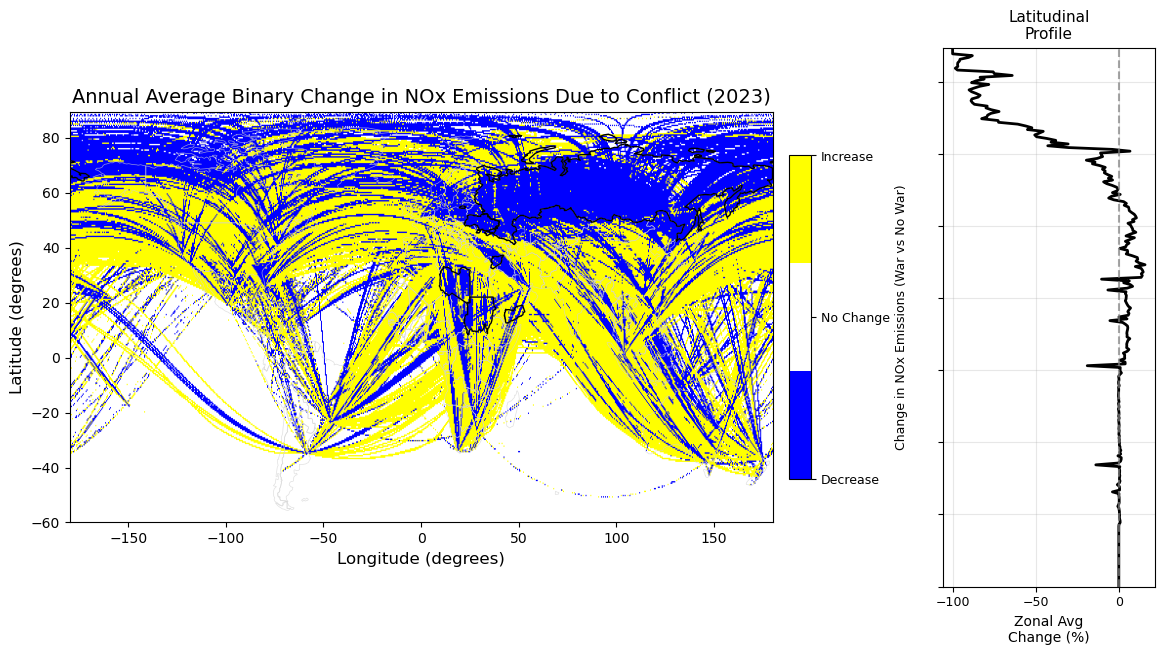

In [5]:
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec

# Calculate and plot the difference in NOx emissions between conflict and no-conflict scenarios

# Initialize arrays to store differences for each month
monthly_differences = []
monthly_nowar_totals = []
month_labels = []

# Create custom binary colormap
import matplotlib.colors as mcolors

# Define colors: blue for decrease, white for no change, yellow for increase
colors = ['blue', 'white', 'yellow']
n_bins = 100
cmap_binary = ListedColormap(colors)

# Loop over each month in the analysis period
for start_time_str_loop in pd.date_range(start=pd.to_datetime(start_time_str), end=pd.to_datetime(stop_time_str), freq='MS', tz='UTC'):
    stop_time_str_loop = (start_time_str_loop + pd.offsets.MonthEnd(1)).replace(hour=23, minute=59, second=59)
    start_time_simple_loop = pd.to_datetime(start_time_str_loop).strftime("%Y-%m-%d")
    stop_time_simple_loop = pd.to_datetime(stop_time_str_loop).strftime("%Y-%m-%d")
    month_year = pd.to_datetime(start_time_str_loop).strftime('%B %Y')
    
    try:
        # Load both conflict and no-conflict NOx emissions grids
        nox_grid_war = np.load(f'/home/omg28/nethome/Data/emissions/{start_time_simple_loop}_to_{stop_time_simple_loop}_NOx_war.npy')
        nox_grid_nowar = np.load(f'/home/omg28/nethome/Data/emissions/{start_time_simple_loop}_to_{stop_time_simple_loop}_NOx_nowar.npy')
        
        # Calculate the difference (war scenario - no war scenario)
        nox_difference = nox_grid_war - nox_grid_nowar
        
        # Sum over altitude to get total difference per (lat, lon) cell
        nox_diff_lat_lon = np.sum(nox_difference, axis=2)
        nox_nowar_lat_lon = np.sum(nox_grid_nowar, axis=2)
        
        monthly_differences.append(nox_diff_lat_lon)
        monthly_nowar_totals.append(nox_nowar_lat_lon)
        month_labels.append(month_year)
        
    except FileNotFoundError:
        print(f"Warning: Emissions data not found for {month_year}")
        continue

# Calculate annual average difference with binary colormap
if monthly_differences:
    annual_avg_difference = np.mean(monthly_differences, axis=0)
    annual_avg_nowar = np.mean(monthly_nowar_totals, axis=0)
    
    # Create binary classification for annual average
    binary_annual = np.zeros_like(annual_avg_difference)
    binary_annual[annual_avg_difference > 0] = 1   # Increase
    binary_annual[annual_avg_difference < 0] = -1  # Decrease
    
    # Calculate zonally averaged relative change (percentage)
    zonal_avg_diff = np.mean(annual_avg_difference, axis=1)
    zonal_avg_nowar = np.mean(annual_avg_nowar, axis=1)
    
    # Calculate relative change as percentage, avoiding division by zero
    zonal_relative_change = np.zeros_like(zonal_avg_diff)
    nonzero_mask = zonal_avg_nowar != 0
    zonal_relative_change[nonzero_mask] = (zonal_avg_diff[nonzero_mask] / zonal_avg_nowar[nonzero_mask]) * 100
    
    # Calculate total annual statistics
    total_increase = np.sum(annual_avg_difference[annual_avg_difference > 0])
    total_decrease = np.sum(annual_avg_difference[annual_avg_difference < 0])
    net_change = np.sum(annual_avg_difference)
    
    # Calculate annual totals for percentage
    annual_war_total = np.sum([np.sum(np.load(f'/home/omg28/nethome/Data/emissions/{pd.to_datetime(start_loop).strftime("%Y-%m-%d")}_to_{(pd.to_datetime(start_loop) + pd.offsets.MonthEnd(1)).strftime("%Y-%m-%d")}_NOx_war.npy')) 
                              for start_loop in pd.date_range(start=pd.to_datetime(start_time_str), end=pd.to_datetime(stop_time_str), freq='MS', tz='UTC')])
    annual_nowar_total = np.sum([np.sum(np.load(f'/home/omg28/nethome/Data/emissions/{pd.to_datetime(start_loop).strftime("%Y-%m-%d")}_to_{(pd.to_datetime(start_loop) + pd.offsets.MonthEnd(1)).strftime("%Y-%m-%d")}_NOx_nowar.npy')) 
                                for start_loop in pd.date_range(start=pd.to_datetime(start_time_str), end=pd.to_datetime(stop_time_str), freq='MS', tz='UTC')])
    
    print(f"Annual {analysis_year} NOx Emissions Statistics:")
    print(f"  Total increase in emissions: {total_increase:.2f} kg/year")
    print(f"  Total decrease in emissions: {total_decrease:.2f} kg/year")
    print(f"  Net change in emissions: {net_change:.2f} kg/year")
    print(f"  Percentage change: {(net_change/annual_nowar_total*100):.4f}%")
    
    # Create figure with subplots
    fig = plt.figure(figsize=(14, 7))
    gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1], hspace=0.05, wspace=0.05)
    
    # Main map subplot
    ax_map = fig.add_subplot(gs[0])
    im = ax_map.imshow(
        binary_annual,
        extent=[-180, 180, lat_bins[0], lat_bins[-2]],
        origin='lower',
        aspect='auto',
        cmap=cmap_binary,
        vmin=-1,
        vmax=1
    )
    
    # Set limits
    ax_map.set_xlim(-180, 180)
    ax_map.set_ylim(-60, lat_bins[-2])
    
    ax_map.set_xlabel('Longitude (degrees)', fontsize=12)
    ax_map.set_ylabel('Latitude (degrees)', fontsize=12)
    ax_map.set_title(f'Annual Average Binary Change in NOx Emissions Due to Conflict ({analysis_year})', fontsize=14)
    ax_map.tick_params(axis='both', labelsize=10)
    
    # Overlay country boundaries with light colors
    try:
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    except (AttributeError, KeyError):
        world = gpd.read_file('ne_110m_admin_0_countries.zip')
    
    # Add light country boundaries
    world.boundary.plot(ax=ax_map, edgecolor='lightgray', linewidth=0.5, alpha=0.7, zorder=5)
    
    # Highlight conflict countries with darker boundaries
    conflict_zones = world[world['NAME'].isin(conflict_countries)] if 'NAME' in world.columns else world[world['name'].isin(conflict_countries)]
    conflict_zones.boundary.plot(ax=ax_map, edgecolor='black', linewidth=1, zorder=10)
    
    # Create colorbar overlaid on the map (top right corner)
    cbar = plt.colorbar(im, ax=ax_map, shrink=0.6, aspect=15, pad=0.02, 
                       ticks=[-1, 0, 1])
    cbar.set_ticklabels(['Decrease', 'No Change', 'Increase'])
    cbar.ax.tick_params(labelsize=9)
    cbar.set_label('Change in NOx Emissions (War vs No War)', fontsize=9)
    
    # Zonal average subplot
    ax_zonal = fig.add_subplot(gs[1], sharey=ax_map)  # share y-axis with main map
    lat_centers = (lat_bins[:-1] + lat_bins[1:]) / 2
    ax_zonal.plot(zonal_relative_change, lat_centers, 'k-', linewidth=2)
    ax_zonal.axvline(x=0, color='gray', linestyle='--', alpha=0.7)
    ax_zonal.set_ylim(ax_map.get_ylim())  # ensure same y-limits
    ax_zonal.set_xlabel('Zonal Avg\nChange (%)', fontsize=10)
    ax_zonal.set_title('Latitudinal\nProfile', fontsize=11)
    ax_zonal.tick_params(axis='both', labelsize=9)
    ax_zonal.grid(True, alpha=0.3)
    
    # Remove y-axis labels for zonal plot since they're shared with main plot
    plt.setp(ax_zonal.get_yticklabels(), visible=False)
    
    plt.show()


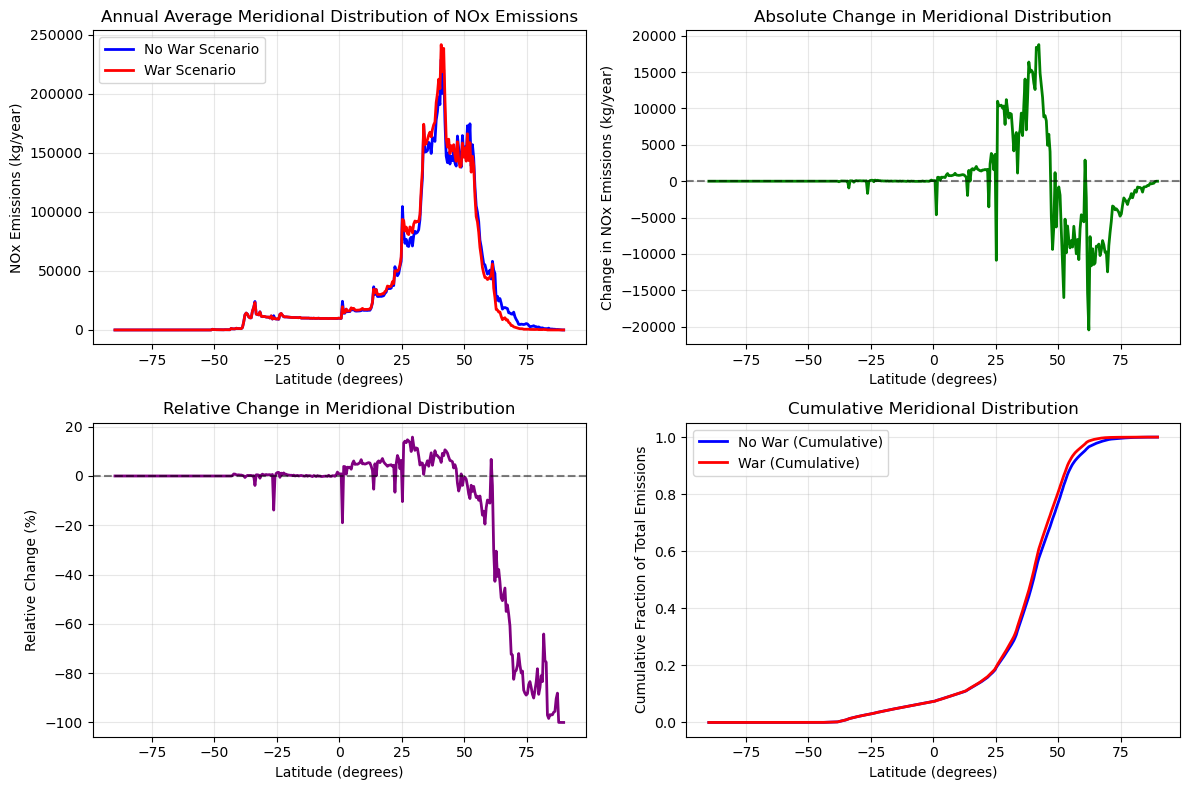


=== Meridional Shift Analysis for 2023 ===
Emission centroid shift: -1.074° latitude
No war centroid: 36.17°N
War centroid: 35.10°N

Regional Distribution Changes:
Northern latitudes (≥30°N):
  No war: 8814209 kg/year (74.9%)
  War: 8705613 kg/year (73.9%)
  Change: -108596 kg/year (-1.23%)

Temperate latitudes (0°-30°N):
  No war: 2088646 kg/year (17.8%)
  War: 2215599 kg/year (18.8%)
  Change: 126953 kg/year (6.08%)

Southern latitudes (<0°):
  No war: 861661 kg/year (7.3%)
  War: 860947 kg/year (7.3%)
  Change: -715 kg/year (-0.08%)

Latitude of maximum increase: 42.2°N (18771 kg/year)
Latitude of maximum decrease: 62.2°N (-20436 kg/year)


In [2]:
# Calculate meridional shift in NOx emissions distribution for 2023
# This analysis examines how the latitudinal distribution of emissions changes due to conflict

# Initialize arrays to store meridional distributions
monthly_nowar_lat = []
monthly_war_lat = []
month_labels = []

# Loop over each month in the analysis period
for start_time_str_loop in pd.date_range(start=pd.to_datetime(start_time_str), end=pd.to_datetime(stop_time_str), freq='MS', tz='UTC'):
    stop_time_str_loop = (start_time_str_loop + pd.offsets.MonthEnd(1)).replace(hour=23, minute=59, second=59)
    start_time_simple_loop = pd.to_datetime(start_time_str_loop).strftime("%Y-%m-%d")
    stop_time_simple_loop = pd.to_datetime(stop_time_str_loop).strftime("%Y-%m-%d")
    month_year = pd.to_datetime(start_time_str_loop).strftime('%B %Y')
    
    try:
        # Load both conflict and no-conflict NOx emissions grids
        nox_grid_war = np.load(f'/home/omg28/nethome/Data/emissions/{start_time_simple_loop}_to_{stop_time_simple_loop}_NOx_war.npy')
        nox_grid_nowar = np.load(f'/home/omg28/nethome/Data/emissions/{start_time_simple_loop}_to_{stop_time_simple_loop}_NOx_nowar.npy')
        
        # Sum over longitude and altitude to get meridional (latitude) distribution
        nox_nowar_lat = np.sum(nox_grid_nowar, axis=(1, 2))  # Sum over lon and alt
        nox_war_lat = np.sum(nox_grid_war, axis=(1, 2))      # Sum over lon and alt
        
        monthly_nowar_lat.append(nox_nowar_lat)
        monthly_war_lat.append(nox_war_lat)
        month_labels.append(month_year)
        
    except FileNotFoundError:
        print(f"Warning: Emissions data not found for {month_year}")
        continue

# Calculate annual average meridional distributions
if monthly_nowar_lat and monthly_war_lat:
    annual_nowar_lat = np.mean(monthly_nowar_lat, axis=0)
    annual_war_lat = np.mean(monthly_war_lat, axis=0)
    
    # Calculate latitude centers for each bin
    lat_centers = (lat_bins[:-1] + lat_bins[1:]) / 2
    
    # Calculate the shift in distribution
    shift_lat = annual_war_lat - annual_nowar_lat
    
    # Calculate relative change (percentage)
    relative_change = np.zeros_like(shift_lat)
    nonzero_mask = annual_nowar_lat > 0
    relative_change[nonzero_mask] = (shift_lat[nonzero_mask] / annual_nowar_lat[nonzero_mask]) * 100
    
    # Plot the meridional distributions
    plt.figure(figsize=(12, 8))
    
    # Subplot 1: Absolute distributions
    plt.subplot(2, 2, 1)
    plt.plot(lat_centers, annual_nowar_lat, 'b-', linewidth=2, label='No War Scenario')
    plt.plot(lat_centers, annual_war_lat, 'r-', linewidth=2, label='War Scenario')
    plt.xlabel('Latitude (degrees)')
    plt.ylabel('NOx Emissions (kg/year)')
    plt.title('Annual Average Meridional Distribution of NOx Emissions')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Absolute difference
    plt.subplot(2, 2, 2)
    plt.plot(lat_centers, shift_lat, 'g-', linewidth=2)
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    plt.xlabel('Latitude (degrees)')
    plt.ylabel('Change in NOx Emissions (kg/year)')
    plt.title('Absolute Change in Meridional Distribution')
    plt.grid(True, alpha=0.3)
    
    # Subplot 3: Relative change (percentage)
    plt.subplot(2, 2, 3)
    plt.plot(lat_centers, relative_change, 'purple', linewidth=2)
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    plt.xlabel('Latitude (degrees)')
    plt.ylabel('Relative Change (%)')
    plt.title('Relative Change in Meridional Distribution')
    plt.grid(True, alpha=0.3)
    
    # Subplot 4: Cumulative distributions (normalized)
    plt.subplot(2, 2, 4)
    cum_nowar = np.cumsum(annual_nowar_lat) / np.sum(annual_nowar_lat)
    cum_war = np.cumsum(annual_war_lat) / np.sum(annual_war_lat)
    plt.plot(lat_centers, cum_nowar, 'b-', linewidth=2, label='No War (Cumulative)')
    plt.plot(lat_centers, cum_war, 'r-', linewidth=2, label='War (Cumulative)')
    plt.xlabel('Latitude (degrees)')
    plt.ylabel('Cumulative Fraction of Total Emissions')
    plt.title('Cumulative Meridional Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate key statistics
    total_nowar = np.sum(annual_nowar_lat)
    total_war = np.sum(annual_war_lat)
    
    # Calculate centroid shift
    centroid_nowar = np.sum(lat_centers * annual_nowar_lat) / total_nowar
    centroid_war = np.sum(lat_centers * annual_war_lat) / total_war
    centroid_shift = centroid_war - centroid_nowar
    
    # Calculate emissions by latitude bands
    northern_lats = lat_centers >= 30
    temperate_lats = (lat_centers >= 0) & (lat_centers < 30)
    southern_lats = lat_centers < 0
    
    northern_nowar = np.sum(annual_nowar_lat[northern_lats])
    northern_war = np.sum(annual_war_lat[northern_lats])
    
    temperate_nowar = np.sum(annual_nowar_lat[temperate_lats])
    temperate_war = np.sum(annual_war_lat[temperate_lats])
    
    southern_nowar = np.sum(annual_nowar_lat[southern_lats])
    southern_war = np.sum(annual_war_lat[southern_lats])
    
    print(f"\n=== Meridional Shift Analysis for {analysis_year} ===")
    print(f"Emission centroid shift: {centroid_shift:.3f}° latitude")
    print(f"No war centroid: {centroid_nowar:.2f}°N")
    print(f"War centroid: {centroid_war:.2f}°N")
    
    print(f"\nRegional Distribution Changes:")
    print(f"Northern latitudes (≥30°N):")
    print(f"  No war: {northern_nowar:.0f} kg/year ({northern_nowar/total_nowar*100:.1f}%)")
    print(f"  War: {northern_war:.0f} kg/year ({northern_war/total_war*100:.1f}%)")
    print(f"  Change: {northern_war-northern_nowar:.0f} kg/year ({(northern_war-northern_nowar)/northern_nowar*100:.2f}%)")
    
    print(f"\nTemperate latitudes (0°-30°N):")
    print(f"  No war: {temperate_nowar:.0f} kg/year ({temperate_nowar/total_nowar*100:.1f}%)")
    print(f"  War: {temperate_war:.0f} kg/year ({temperate_war/total_war*100:.1f}%)")
    print(f"  Change: {temperate_war-temperate_nowar:.0f} kg/year ({(temperate_war-temperate_nowar)/temperate_nowar*100:.2f}%)")
    
    print(f"\nSouthern latitudes (<0°):")
    print(f"  No war: {southern_nowar:.0f} kg/year ({southern_nowar/total_nowar*100:.1f}%)")
    print(f"  War: {southern_war:.0f} kg/year ({southern_war/total_war*100:.1f}%)")
    print(f"  Change: {southern_war-southern_nowar:.0f} kg/year ({(southern_war-southern_nowar)/southern_nowar*100:.2f}%)")
    
    # Find latitude of maximum change
    max_increase_lat = lat_centers[np.argmax(shift_lat)]
    max_decrease_lat = lat_centers[np.argmin(shift_lat)]
    
    print(f"\nLatitude of maximum increase: {max_increase_lat:.1f}°N ({np.max(shift_lat):.0f} kg/year)")
    print(f"Latitude of maximum decrease: {max_decrease_lat:.1f}°N ({np.min(shift_lat):.0f} kg/year)")

else:
    print("No emissions data found for analysis")